# Tutorial on Interfacing with GeoModels using PyVista and Trame

## Introduction

This Jupyter notebook serves as a guide to demonstrate how to leverage the powerful capabilities of PyVista, Trame for interfacing with GeoModels. These tools provide robust frameworks for rendering, manipulating, and analyzing 3D geological models using the Visualization Toolkit (VTK). PyVista offers some advantages over other visualization tools, with its ability to interface directly with the numpy arrays that store the core Geomodel data structures. Some purpose built displays modes have been developed for viewing Geomodels, but the full power of PyVista can be used to extend the library into more advanced custom visualization and analysis.

## Purpose

The purpose of this notebook is to provide a step-by-step tutorial on how to utilize PyVista to work with geological models. We will cover the following key areas:

1. **Introduction to PyVista, Trame**: Understanding the core functionalities and features of each library.
2. **Setting Up the Environment**: Instructions on how to install and configure the necessary libraries.
3. **Loading and Visualizing GeoModels**: Techniques for importing and visualizing geological models using PyVista.
4. **Interactive Visualization with Trame**: Utilizing Trame to create interactive web-based visualizations.

By the end of this notebook, you will have an understanding of how to effectively interface with GeoModels.

## Libraries Overview

- **PyVista**: A flexible and easy-to-use library for 3D plotting and mesh analysis based on VTK. It provides a high-level API for visualizing and analyzing 3D data.
  - [PyVista Documentation](https://docs.pyvista.org/)
  - [PyVista Tutorials](https://docs.pyvista.org/examples/index.html)
  - [PyVista Installation](https://docs.pyvista.org/getting-started/installation.html)

- **Trame**: A framework for building interactive web applications with VTK. It allows seamless integration of VTK-based visualizations into web interfaces, enabling interactive exploration of 3D models.
  - [Trame Documentation](https://kitware.github.io/trame/)

- **VTK (Visualization Toolkit)**: An open-source software system for 3D computer graphics, image processing, and visualization. VTK forms the backbone of both PyVista and Trame, offering extensive capabilities for 3D data processing and rendering.
  - [VTK Documentation](https://vtk.org/)

## Getting Started

To begin, ensure you have the necessary libraries installed. You can set up your environment by following the installation instructions provided in the PyVista installation instructions above. In addition, if planning to use Jupyter or html web embeddings for visualization you should install Trame as well by following the [PyVista Tutorials Getting Started](https://tutorial.pyvista.org/getting-started.html) for installation and [PyVista in Jupyter](https://tutorial.pyvista.org/tutorial/00_jupyter/index.html) for Jupyter notebook setup.

## Jupyter Rendering
For this notebook the `'static'` rendering backend is used so that the rendered images can be saved as part of the notebook. Important to note is that the default backend can be changed to an interactive viewer, which is recommended for fully interacting with the trame framework.

See more information with the [Jupyter Notebook Plotting](https://docs.pyvista.org/user-guide/jupyter/) guide. For quick access to interactive plots, uncomment the line to set the backend to `'client'`



In [1]:
import pyvista as pv
import numpy as np

from structgeo import model as geo
from structgeo import plot as geovis
from structgeo import probability as rv

# Set rendering mode for notebook, use 'client' for interactive rendering
pv.set_jupyter_backend('static')
# pv.set_jupyter_backend('client')    # Uncomment for interactive rendering

First a model should be generated to create a grid of rock value samples.

In [2]:
# Define a function to generate a model
def generate_model():
    # Start with some model specifications
    resolution = 128
    # Cubic model keeps 
    max_x = 10
    min_x = - max_x
    bounds = (min_x,max_x)
    model = geo.GeoModel(bounds, resolution)
    # Bedrock layer
    bedrock = geo.Bedrock(-5, 0)
    
    sb = geo.SedimentBuilder(1,6,2,8)
    sediment = geo.Sedimentation(*sb.get_layers())
    
    fault = geo.Fault(dip=63, rake = 32)
    sediment2 = geo.Sedimentation(*sb.get_layers())
    
    model.add_history([bedrock, sediment, fault, sediment2])
    model.compute_model()
    return model

model = generate_model()

The Geomodel holds data in a few different forms. It has three mesh grid arrays X, Y, Z forming the set of points, an xyz array that is $n\times3$ of the the $(x,y,z)$ points, and a final data array for the cell values of the rock. Some time snapshots that record the model states where rock assignments were applied are also stored in the Geomodel mesh_snapshots and data_snapshots. With the $0$ index position for the time of the snapshot.

In [3]:
import pandas as pd
# Collect shapes in a dictionary
shape_dict = {
    "model.X": model.X.shape,
    "model.Y": model.Y.shape,
    "model.Z": model.Z.shape,
    "model.xyz": model.xyz.shape,
    "model.data": model.data.shape,
    "model.mesh_snapshots": model.mesh_snapshots.shape,
    "model.data_snapshots": model.data_snapshots.shape
}

# Convert the dictionary to a pandas DataFrame
shape_df = pd.DataFrame(list(shape_dict.items()), columns=["Attribute", "Shape"])

# Display the DataFrame
print(shape_df)

              Attribute            Shape
0               model.X  (128, 128, 128)
1               model.Y  (128, 128, 128)
2               model.Z  (128, 128, 128)
3             model.xyz     (2097152, 3)
4            model.data       (2097152,)
5  model.mesh_snapshots  (2, 2097152, 3)
6  model.data_snapshots     (2, 2097152)


The data can be visualized with PyVista in a few different ways. A mesh approach over a structured grid assigns calculated data values aa point on an interconnected mesh. This differs from a true voxel representation since each of the sample points do not have any volume. The space between them is filled using interpolation which will produce non-categorical values.


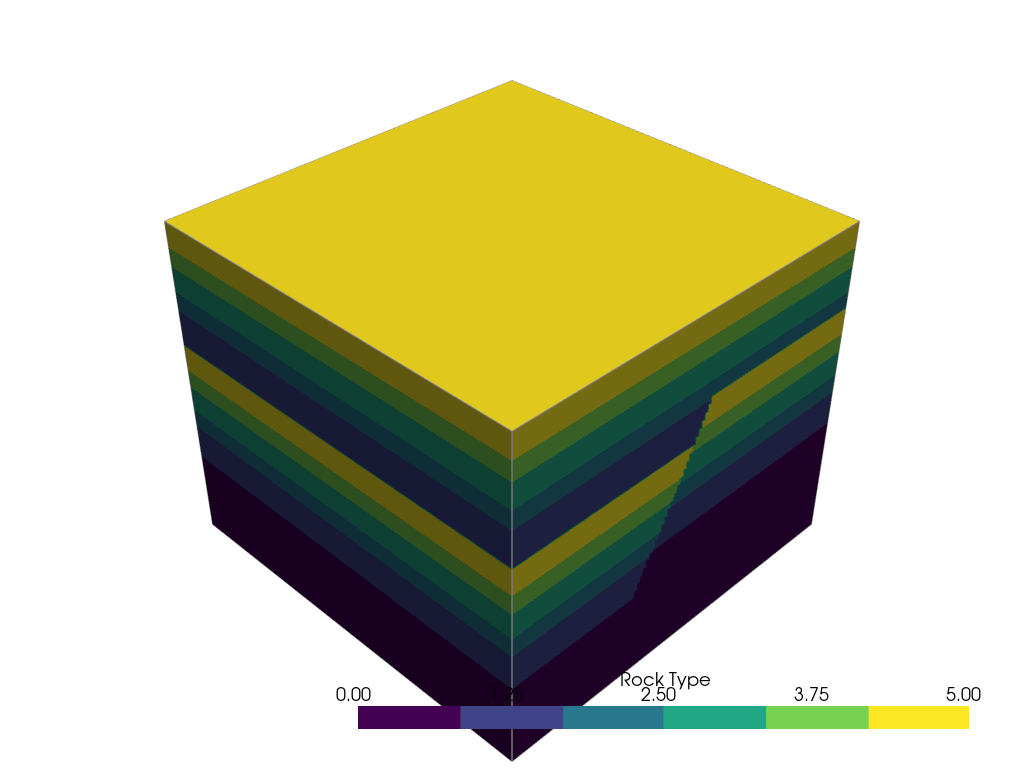

In [4]:
# Meshgrid representation in Pyvista
mesh = pv.StructuredGrid(model.X, model.Y, model.Z)
# The data is not in the correct ordering though, so we shape back to 3D grid and then ravel to 1D
mesh['Rock Type'] = model.data.reshape(model.X.shape).ravel(order='F')
mesh = mesh.threshold(-1, all_scalars=True) # Filter out the nans

# Plot the model mesh with interpolated values across mesh cells
p = pv.Plotter()
p.add_mesh(mesh, scalars='Rock Type', categories=True )
p.add_bounding_box()
p.show()

On a more complicated model, the interpolation becomes apparent and produces image artifacts. Notice the interpolation at the interface of rock layers with values that have large differences. The interpolation will produce color map gradients at their interface.

In [5]:
def make_history():
    # All units are in meters
    basement_level = -1500
    bedrock = geo.Bedrock(-1500,0) 
    sb = geo.SedimentBuilder(1,2000,7,7)
    values, thicknesses = sb.get_layers()        
    sediment1 = geo.Sedimentation(values, thicknesses, base = basement_level)
    
    # Add micro fold noise to the model
    def noise_fold_params():
        wave_generator = rv.FourierWaveGenerator(num_harmonics=5, smoothness=.8)
        return {            
            'strike': np.random.uniform(0, 360),
            'dip': np.random.uniform(0, 360),
            'rake': np.random.uniform(0, 360),
            'period': np.random.uniform(100, 800),
            'amplitude': np.random.uniform(5,15),
            'periodic_func': wave_generator.generate()
        }
    sediment_noise = [geo.Fold(**noise_fold_params()) for _ in range(np.random.randint(4, 7))]

    # Add a larger fold to the model
    wave_generator = rv.FourierWaveGenerator(num_harmonics=3, smoothness=1.2)    
    damped_fourier = wave_generator.generate()
    larger_fold = geo.Fold(strike=30, dip=70, rake=15, period=4000, amplitude=500, periodic_func=damped_fourier)
    
    # Unconformity
    unconformity = geo.UnconformityBase(0)
    
    # Bounce back on the larger fold
    larger_fold_rev = geo.Fold(strike=30, dip=70, rake=15, period=4000, amplitude=-200, periodic_func=damped_fourier)
    
    # Dikes
    start_value =  sediment1.last_value() + 1
    widths = [10, 30, 50, 70, 90]
    
    dikes = []
    for i in range(5):
        value = start_value + i        
        dike = geo.Dike(35 + 2*i,50 - 3*i,widths[i],origin = (100,200- (i**1.2) * 300,0), value= value )
        dikes += [dike]

    large_fault = geo.Fault(strike=30, dip=70, rake=45, amplitude=300, origin=(0,0,0))       
    tilt = geo.Tilt(strike=-40, dip=8, origin=(0,0,0)) 
    
    # Go to next sequence in values
    value = dikes[-1].value + 1    
    sedimentation2 = geo.Sedimentation(list(range(value, value + 6)), [155,145,110,155,145,110], base = -1200)
    
    # Final Bend
    bend = geo.Fold(strike=30+90, dip=0, rake=15, period=8000, amplitude=-500)
    history = [bedrock,sediment1] + sediment_noise + [larger_fold, unconformity, larger_fold_rev] + dikes + [large_fault, tilt, sedimentation2, bend ]
    return history

history = make_history()

In [6]:
model = geo.GeoModel(bounds = (-1920,1920), resolution=128)
model.add_history(history)
model.compute_model()

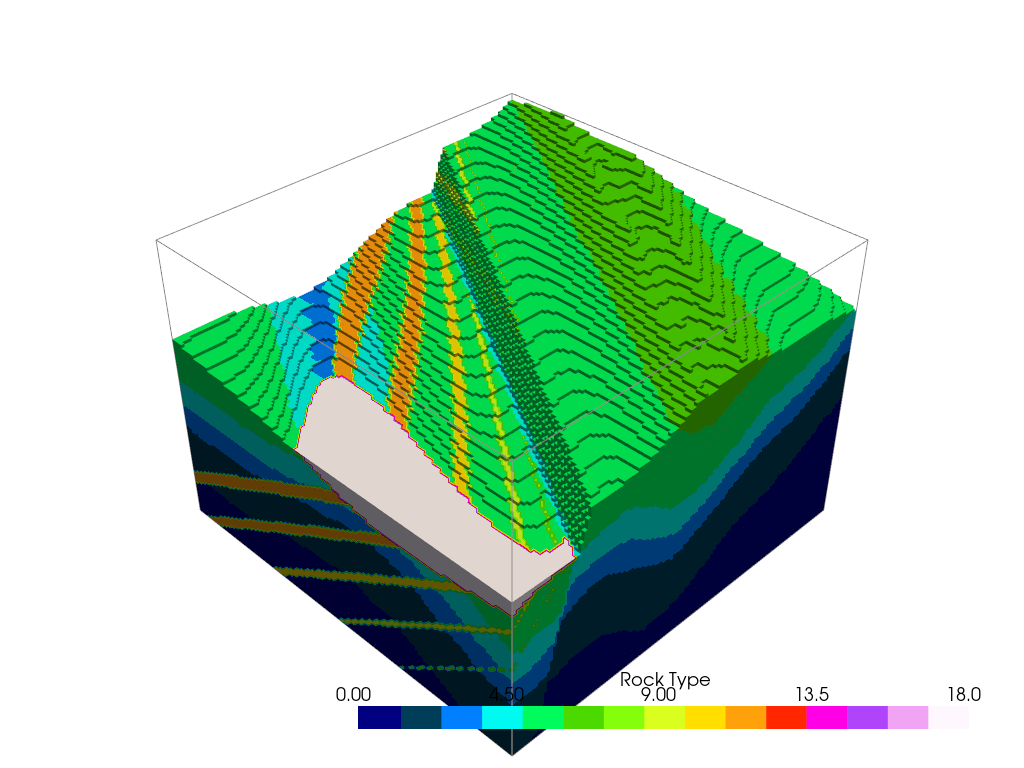

In [7]:
# Meshgrid representation in Pyvista
mesh = pv.StructuredGrid(model.X, model.Y, model.Z)
# The data is not in the correct ordering though, so we shape back to 3D grid and then ravel to 1D
mesh['Rock Type'] = model.data.reshape(model.X.shape).ravel(order='F')
mesh = mesh.threshold(-1, all_scalars=True) # Filter out the nans

# Plot the model mesh with interpolated values across mesh cells
p = pv.Plotter(notebook=True)
p.add_mesh(mesh, scalars='Rock Type', cmap='gist_ncar', categories=True)
p.add_bounding_box()
p.show()

A solution is to instead define a grid of *cells* where the data is assigned to a volume instead of a point. This is a voxel representation and does not require any interpolation to fill the volume. However, the cell array needs to be constructed from the model parameters. Note that when assigning data to a PyVista datatype, it can automatically deduce it it is for the points or the cells by matching the array size to the number of points or cells in the mesh.

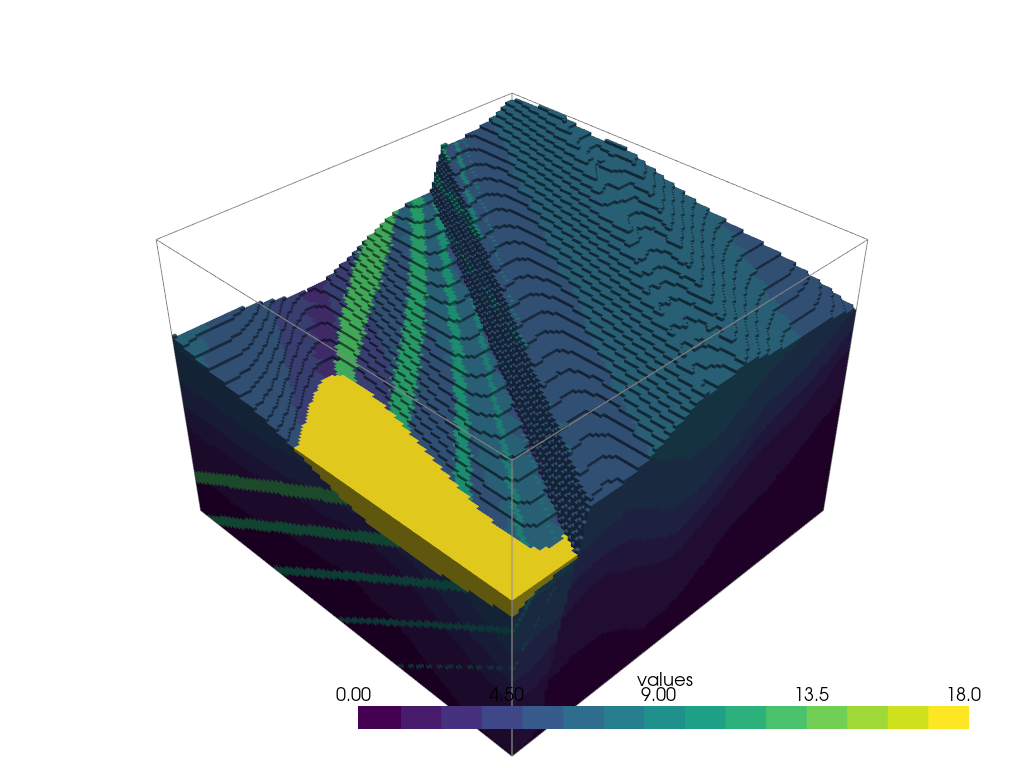

In [8]:
# Create a padded grid with n+1 nodes and node spacing equal to model sample spacing    
dimensions = tuple(x + 1 for x in model.resolution)
spacing = tuple((x[1] - x[0])/(r-1) for x,r in zip(model.bounds, model.resolution))
# pad origin with a half cell size to center the grid
origin = tuple(x[0] - cs/2 for x,cs in zip(model.bounds, spacing))
# Create a structured grid with n+1 nodes in each dimension forming n^3 cells
grid = pv.ImageData(
    dimensions = dimensions,
    spacing = spacing,
    origin = origin,
)    
# Necessary to reshape data vector in Fortran order to match the grid
rock_vals = model.data.reshape(model.resolution).ravel(order='F')
grid['values'] = rock_vals

# Alternatively a direct assignment to cell data:
grid.cell_data['values'] = rock_vals
grid = grid.threshold(-.5, all_scalars=True)

# The same functionality can be achieved with a library call
grid = geovis.get_voxel_grid_from_model(model, threshold=-.5)

p = pv.Plotter()
p.add_mesh(grid, scalars='values', categories=True)
p.add_bounding_box()
p.show()

Now we may want to inspect the rock structures in their 3d shape within the context of the overall model. An approach shown here illustrates many of the PyVista features that can be used to visualize the model.

A **voxel grid** is created from the Geomeodel data which has the rock types mapped to each cell. The standard renderings seen so far only show the outer surface of the volume. To see inside, we can mask out only the values of a particular rock type and then plot them. To view them all at once, a subplot scheme is used where, in this case taking the minimal square grid of subplots that can show all categories. In addition, the views between the subplots can be coordinated to show the same orientation and zoom level.

Note that when rendering a voxel volume using `add_mesh()`, PyVista is actually rendering the outer surface of the volume by first extracting the enclosed surface. This is an expensive operation to run, which is why it is best to explicitly do it outside of the for-loop only once. The outer surface can be reused in each subplot to show the context surrounding the rock type in the model.

Num categories: 15
Rows: 4, Cols: 4


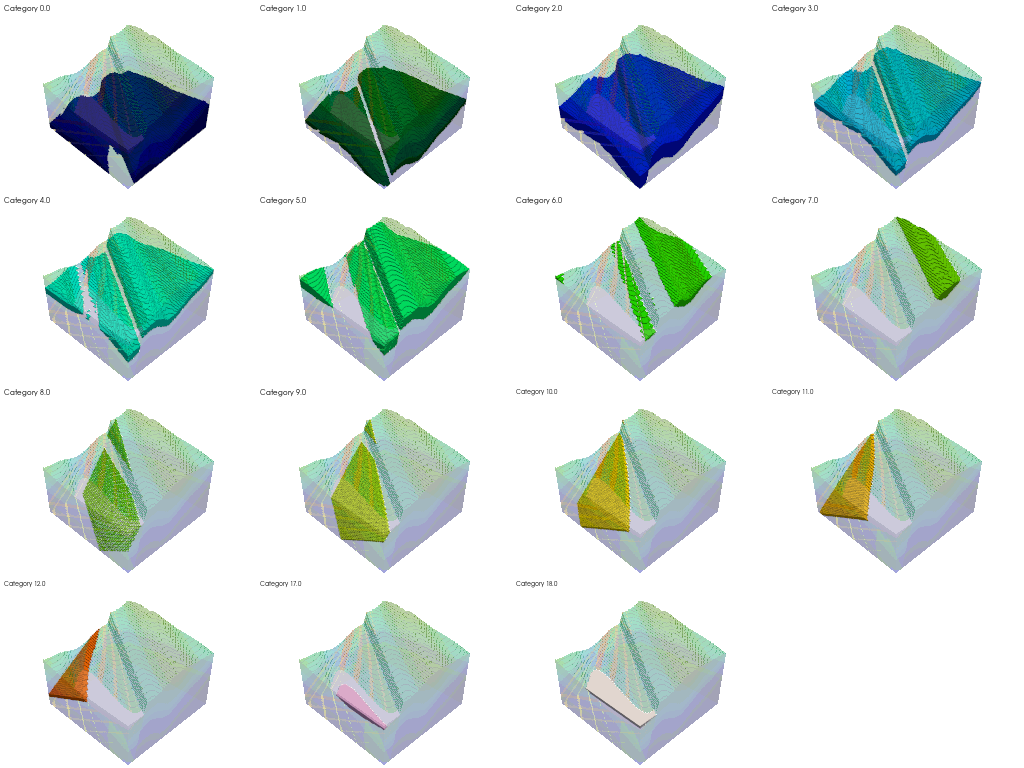

In [9]:
import numpy as np

cfg = geovis.get_plot_config()
cfg['scalar_bar_args'] = None

def calculate_grid_dims(n):
    """ Calculate grid dimensions that are as square as possible. """
    sqrt_n = np.sqrt(n)
    rows = np.ceil(sqrt_n)
    cols = rows
    return int(rows), int(cols)

grid = geovis.get_voxel_grid_from_model(model, threshold=-.5)
# Plot each rock structure individually using thresholding
cats = np.unique(grid['values'])

print(f"Num categories: {len(cats)}")

# Calculate rows and columns for the subplot grid
num_cats = len(cats)
rows, cols = calculate_grid_dims(num_cats)
print(f"Rows: {rows}, Cols: {cols}")

# Create a plotter with specified rows and columns
p = pv.Plotter(shape=(rows, cols), border=False)

# Determine the global color limits for the scalar values
clim = [grid['values'].min(), grid['values'].max()]

skin = grid.extract_surface()

for i, cat in enumerate(cats):
    row, col = divmod(i, cols)
    p.subplot(row, col)

    # Add the translucent full mesh
    p.add_mesh(skin, scalars='values', cmap=cfg['cmap'], clim=clim,
               opacity=0.2, show_scalar_bar=False)

    # Create a mask for the current category
    cat_mask = grid['values'] == cat
    
    # Apply the mask to extract only the current category's voxels
    category_grid = grid.extract_cells(cat_mask)

    # Add the category mesh
    p.add_mesh(category_grid, scalars='values', cmap=cfg['cmap'], clim=clim,
               opacity=1.0, show_scalar_bar=False)

    # Optional: Set the title for the subplot
    p.add_text(f"Category {cat}", position='upper_left', font_size=4)

# Link all views to synchronize interactions such as rotation and zooming
p.link_views()

# Display all subplots
p.show()
   



Need some help with one of the functions in this notebook? Check out the [PyVista API Reference](https://docs.pyvista.org/api/core/index.html) for detailed information on each function. Or simply call the Pythonic help function on the object to get the docstring.

```python
help(object)
```

In [10]:
# help(pv.ImageData)    # Commented out to suppress output

## Library Functions
Now for a demonstraition of some of the available library functions for viewing the Geomodel data.

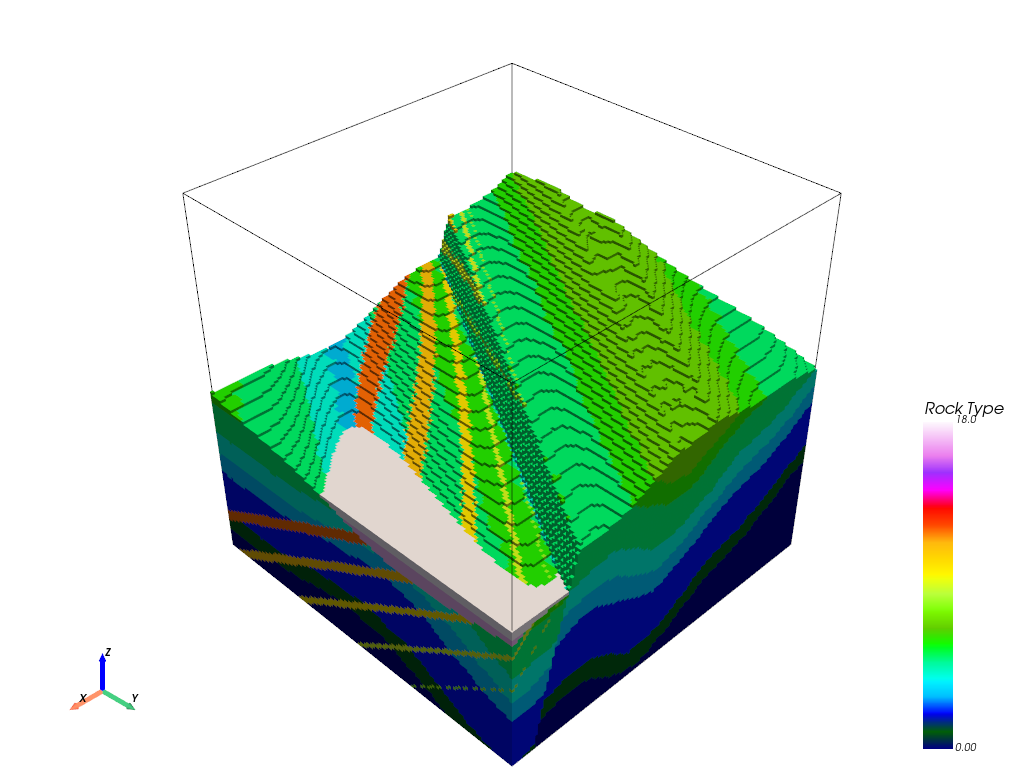

In [11]:
p = geovis.volview(model, threshold=-.5, show_bounds=False)
p.show()

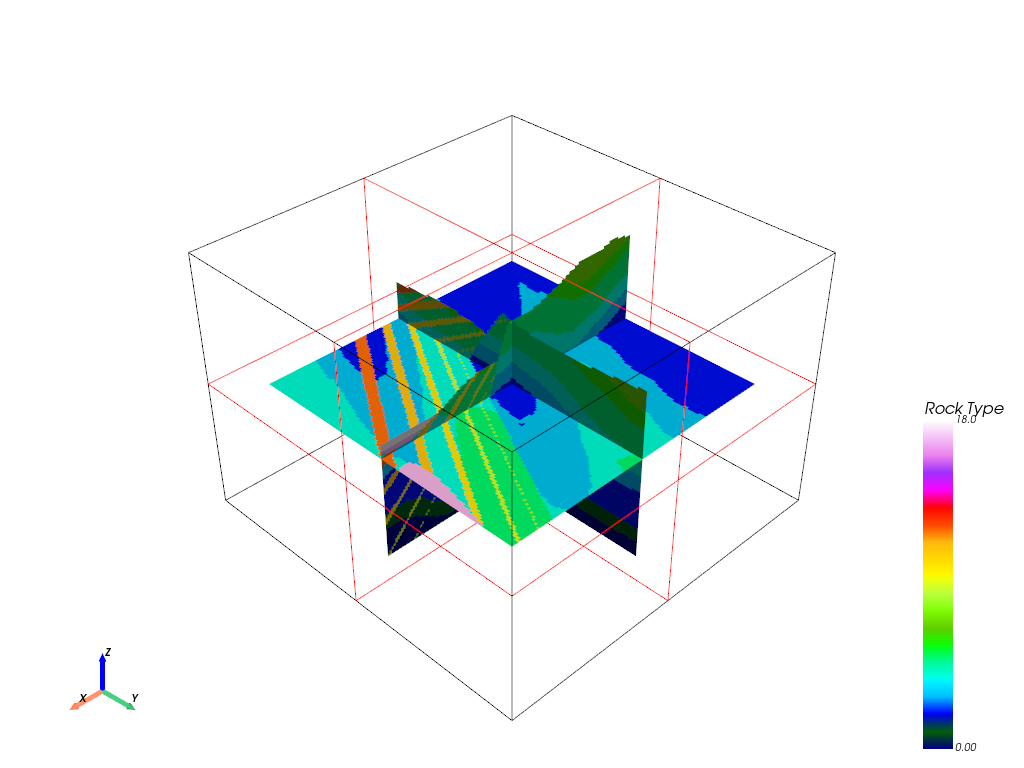

In [12]:
p = geovis.orthsliceview(model, threshold=-.5)
p.show()    

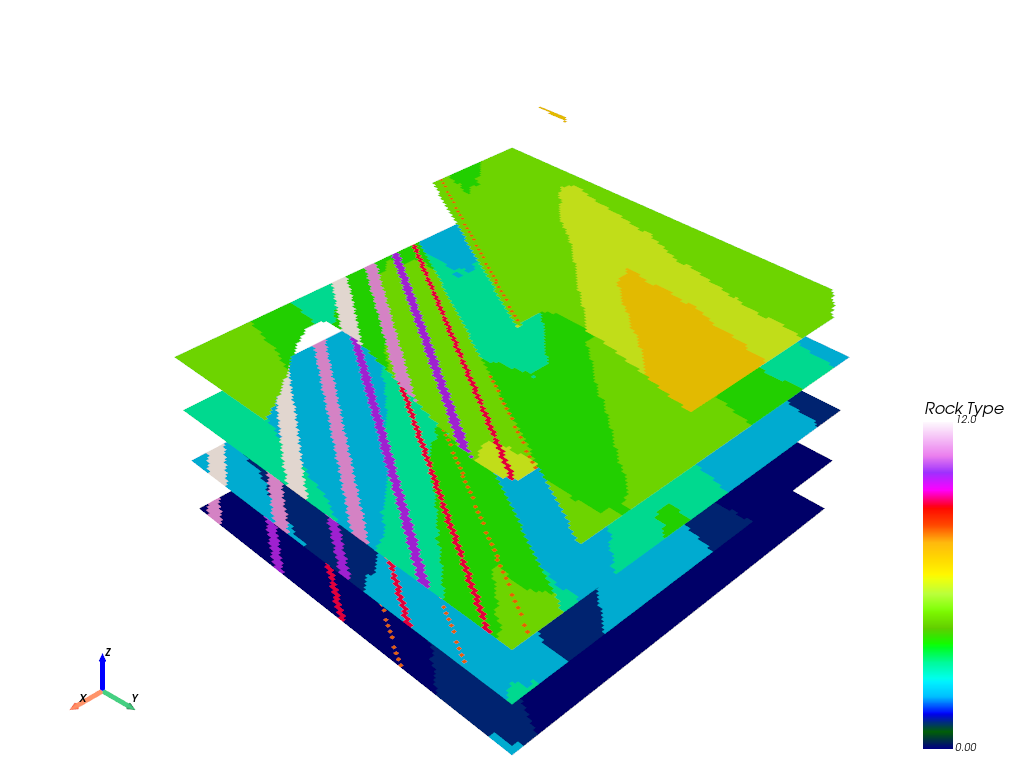

In [13]:
p = geovis.nsliceview(model, n=6, axis='z', threshold=-.5)
p.show()

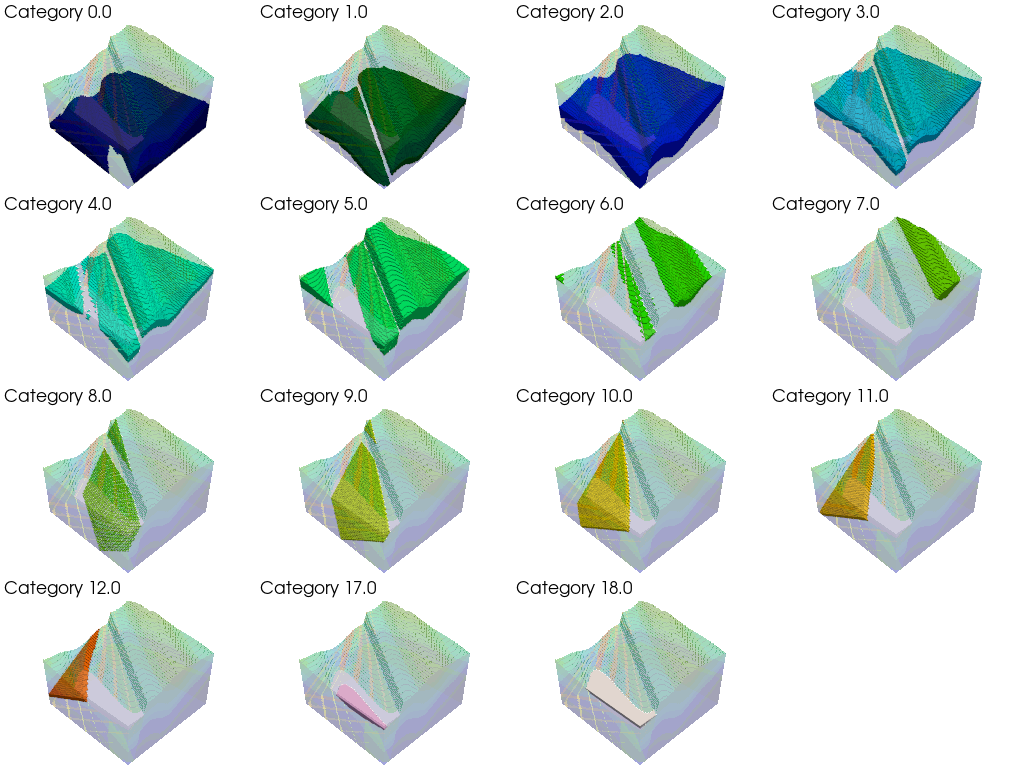

In [14]:
p = geovis.categorical_grid_view(model, threshold=-.5)
p.show()

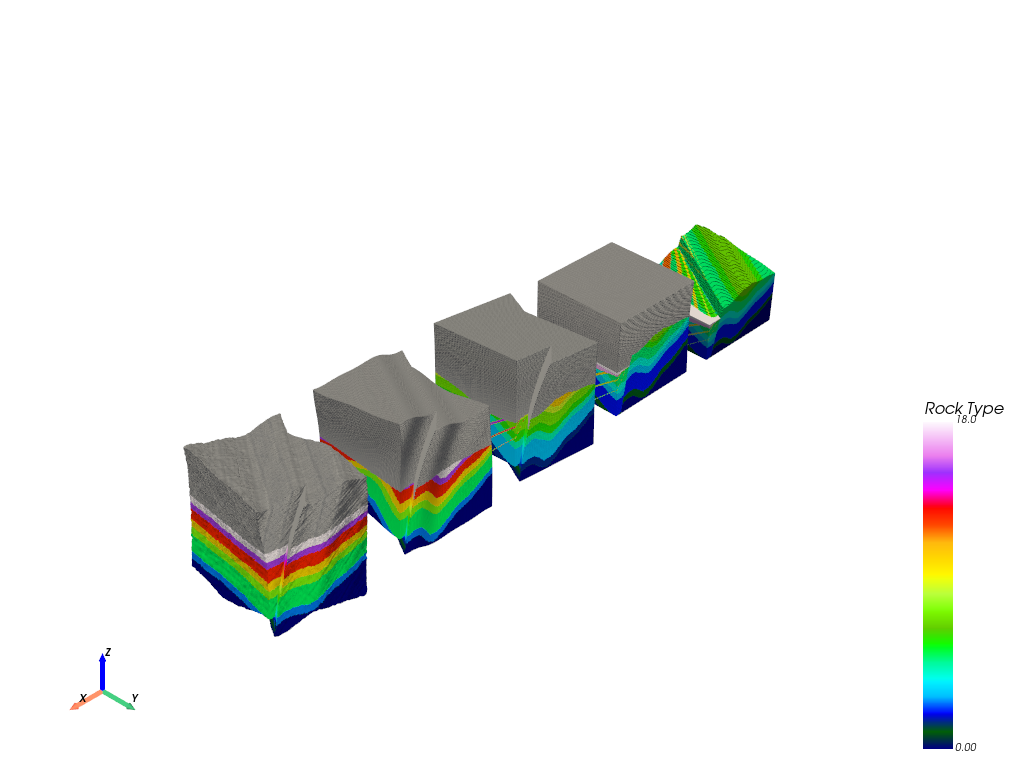

In [15]:
p = geovis.transformationview(model, threshold=-.5)
p.show()

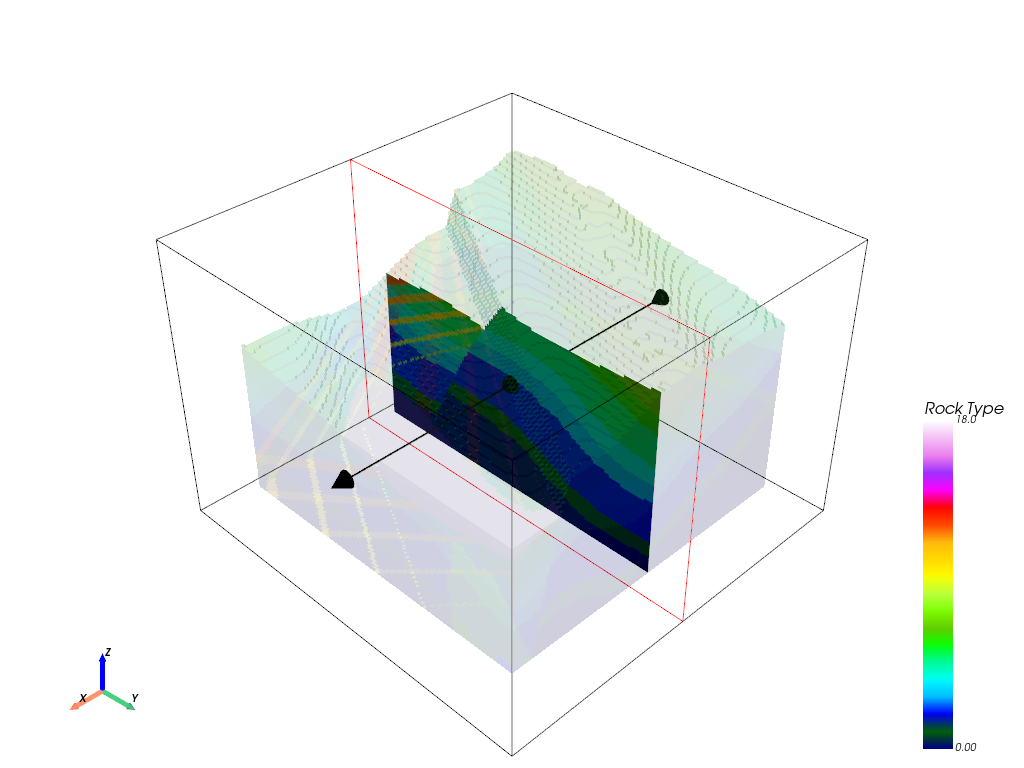

In [16]:
p = geovis.onesliceview(model, threshold=-.5)
p.show()